## 1) Libraries

### 1.1) Libraries

In [1]:
import math
import datetime
import inflection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import random
import warnings
import pickle

from flask                 import Flask, request, Response
from tabulate              import tabulate
from boruta                import BorutaPy
from scipy                 import stats
from tabulate              import tabulate
from matplotlib            import gridspec
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso



/home/joaohenritm/anaconda3/envs/rossman/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 1.2) Helper Functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 30

    sns.set()
jupyter_settings()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2- (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = k - (r-1)**2/(n-1)
    
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max()  - datetime.timedelta(days=k*7*6)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*7*6)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset

        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame({'Model Name': model_name,
             'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
             'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
             'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 2) Load Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 3) Data Description

In [64]:
df1 = pd.DataFrame(df_raw)

### 3.1) Renaming Columns

In [65]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

### 3.2) Data Dimensions

In [66]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### 3.3) Data Types

In [67]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 3.4) Check NA

In [68]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 3.5) Fillout NA

In [69]:
df1['competition_distance'].max()

75860.0

In [70]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


### 3.6) Change Types

In [71]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [72]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 3.7) Descriptive Statistical

In [73]:
df1.describe()

num_attributes = df1.select_dtypes(include=['int64', 'float64'])
# kurtosis and skew
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d1, d2]).T.reset_index()
m.columns = ['attributes', 'skew', 'kurtosis']

In [74]:
m

,attributes,skew,kurtosis
0,store,-0.00095,-1.20052
1,day_of_week,0.00159,-1.24687
2,sales,0.64146,1.77837
3,customers,1.59865,7.09177
4,open,-1.75804,1.09072
5,promo,0.48784,-1.76202
6,school_holiday,1.67784,0.81515
7,competition_distance,10.24234,147.78971
8,competition_open_since_month,-0.04208,-1.23261
9,competition_open_since_year,-7.23566,124.07130


In [75]:
df1.describe()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
count,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000
mean,558.42973,3.99834,5773.81897,633.14595,0.83011,0.38151,0.17865,5935.44268,6.78685,2010.32484,0.50056,23.61903,2012.79330,0.16110
std,321.90865,1.99739,3849.92618,464.41173,0.37554,0.48576,0.38306,12547.65300,3.31109,5.51559,0.50000,14.31006,1.66266,0.36762
min,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,20.00000,1.00000,1900.00000,0.00000,1.00000,2009.00000,0.00000
25%,280.00000,2.00000,3727.00000,405.00000,1.00000,0.00000,0.00000,710.00000,4.00000,2008.00000,0.00000,12.00000,2012.00000,0.00000
50%,558.00000,4.00000,5744.00000,609.00000,1.00000,0.00000,0.00000,2330.00000,7.00000,2012.00000,1.00000,22.00000,2013.00000,0.00000
75%,838.00000,6.00000,7856.00000,837.00000,1.00000,1.00000,0.00000,6910.00000,10.00000,2014.00000,1.00000,37.00000,2014.00000,0.00000
max,1115.00000,7.00000,41551.00000,7388.00000,1.00000,1.00000,1.00000,200000.00000,12.00000,2015.00000,1.00000,52.00000,2015.00000,1.00000


<AxesSubplot:xlabel='sales', ylabel='Density'>

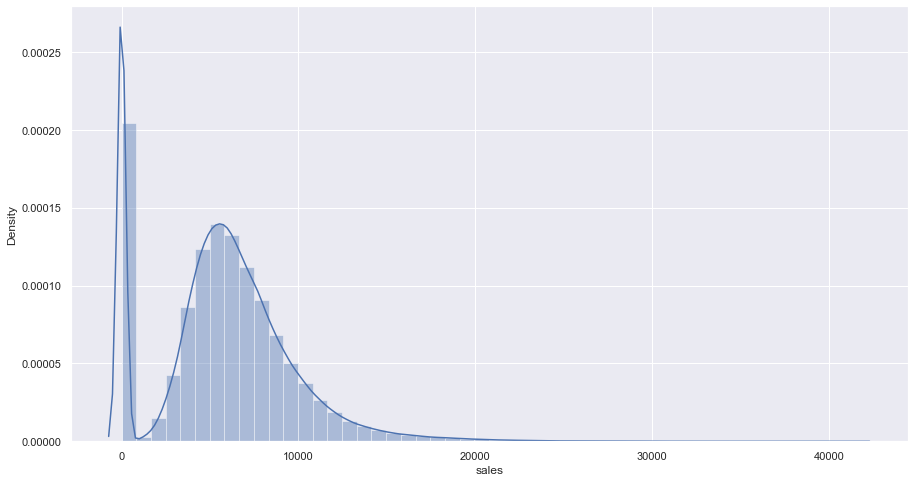

In [76]:
sns.distplot(df1['sales'])

### 3.8) Categorical Attributes

In [77]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

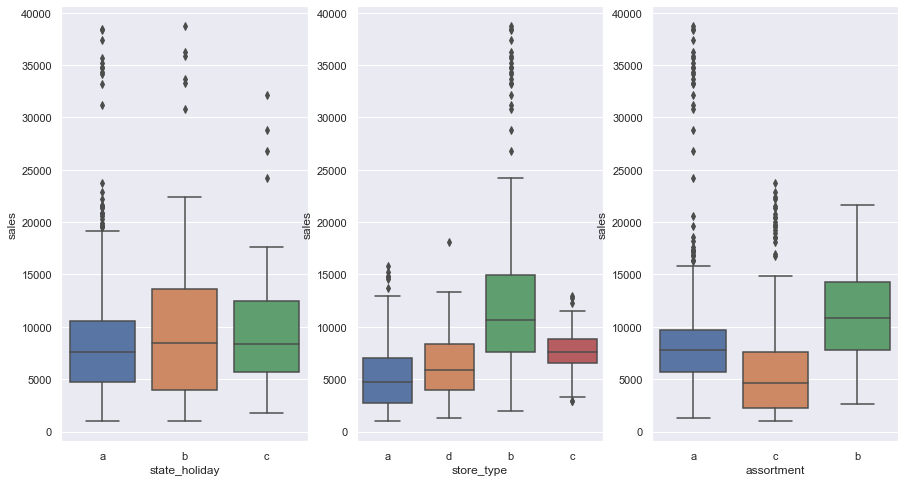

In [78]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

## 4) Feature Engineering

In [79]:
df2 = df1

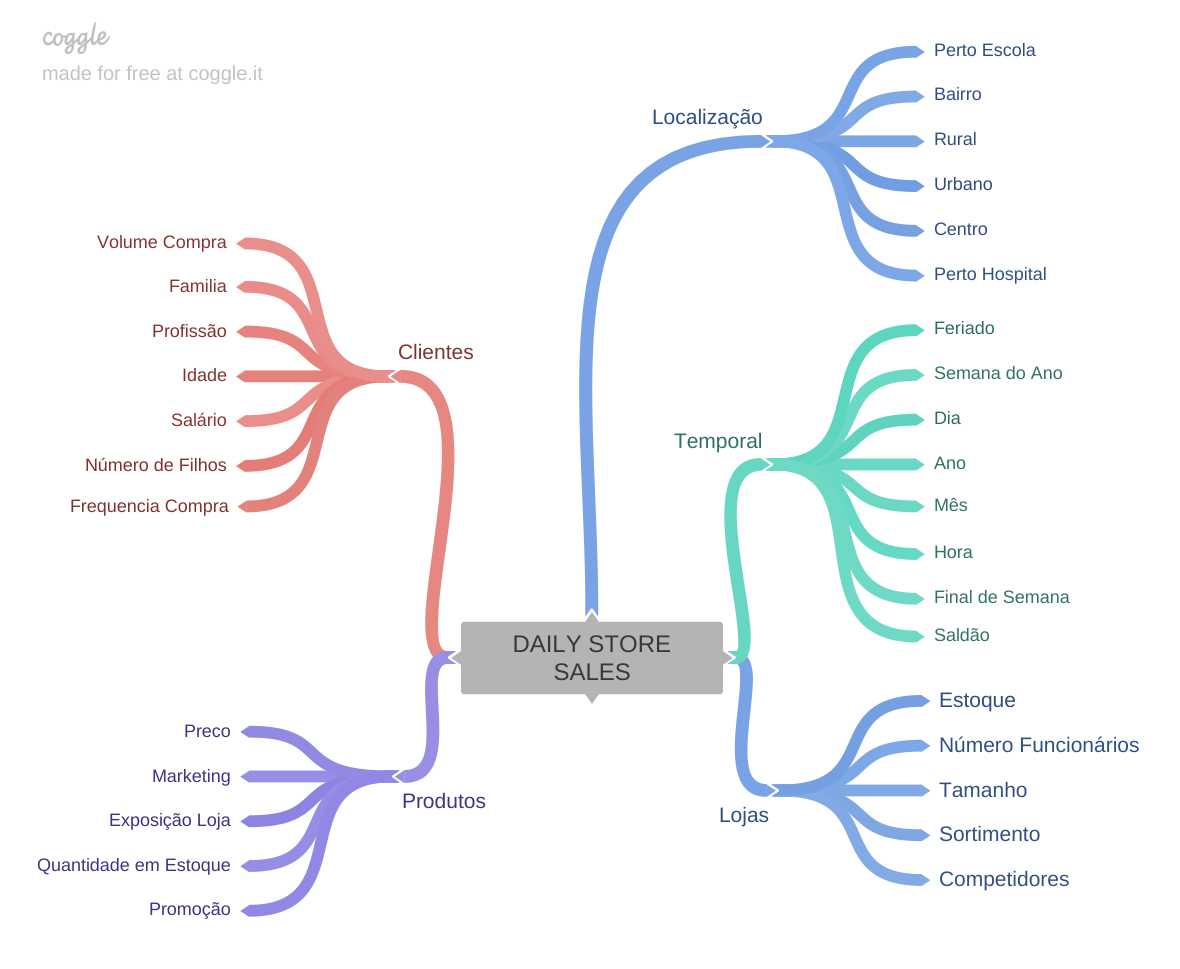

In [80]:
Image('MindMap.png')

### 4.1) Criação das Hipoteses

#### 4.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vendem mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

#### 4.1.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 4.1.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.



### 4.2) Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


### 4.3) Feature Engineering

In [81]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week']= ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment 
df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 5) Filtering Rows and Columns

In [82]:
df3 = df2

In [83]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 5.1) Filtering Rows

In [84]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 5.2) Filtering Columns

In [85]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## 6) Exploratory Data Analysis

In [86]:
df4 = df3

### 6.1) Univariated Analysis

#### 6.1.1) Response Variable

<AxesSubplot:xlabel='sales'>

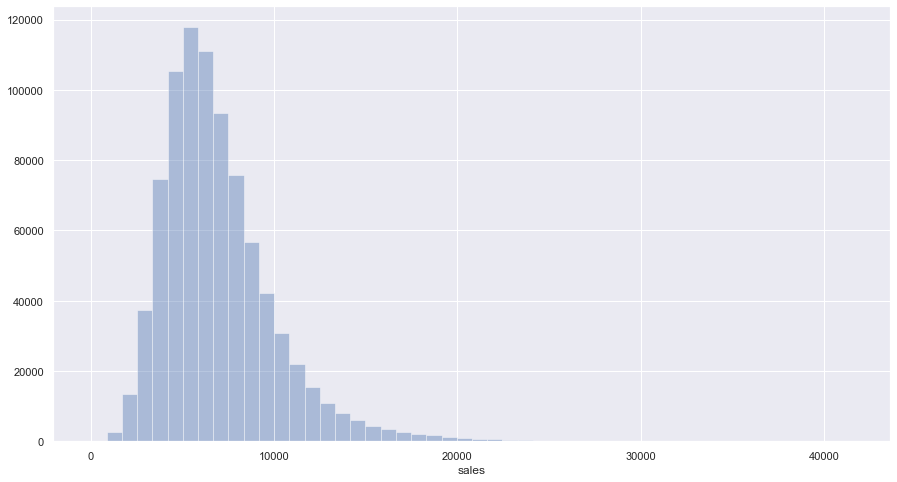

In [87]:
sns.distplot(df4['sales'], kde=False)

#### 6.1.2) Numerical Variable

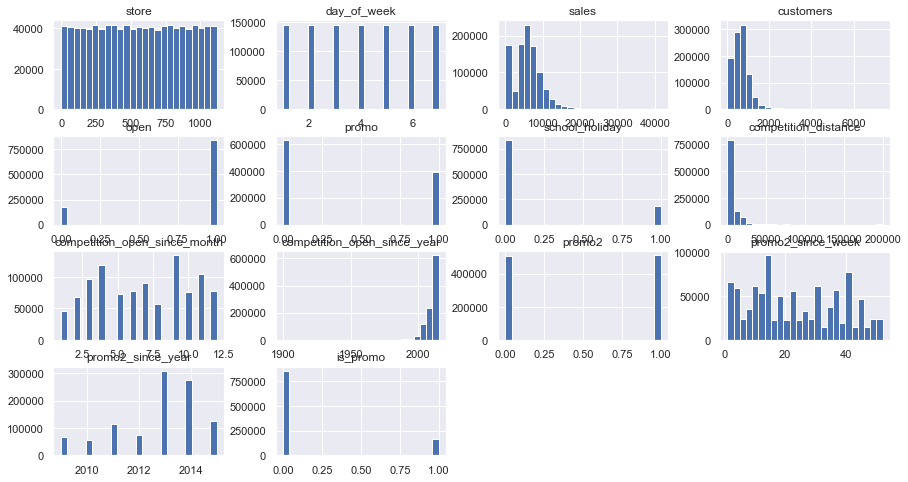

In [88]:
num_attributes.hist(bins=25);

#### 6.1.3) Categorical Variable

In [89]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

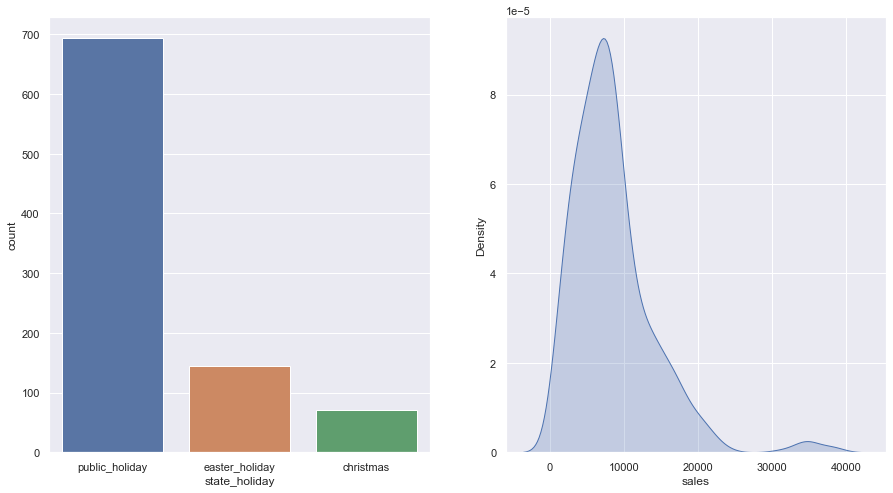

In [90]:
# state holiday

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)

<AxesSubplot:xlabel='sales', ylabel='Density'>

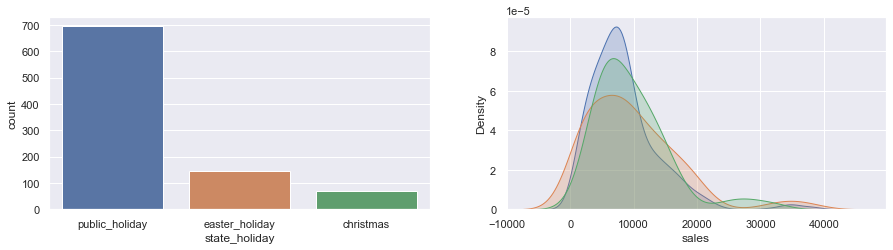

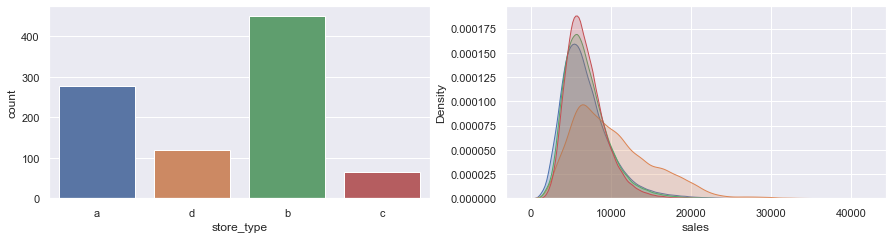

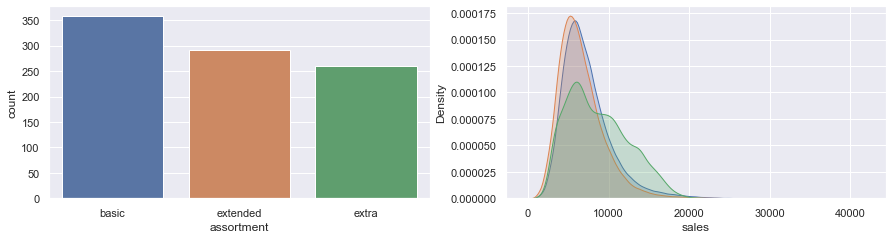

In [91]:
# state_holiday
plt.figure(figsize=(15,12))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.figure(figsize=(15,12))
plt.subplot(3, 2, 3)
sns.countplot(a['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


# assortment
plt.figure(figsize=(15,12))
plt.subplot(3, 2, 5)
sns.countplot(a['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

### 6.2) Bivariated Analysis

#### H1) Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

<AxesSubplot:xlabel='year_week'>

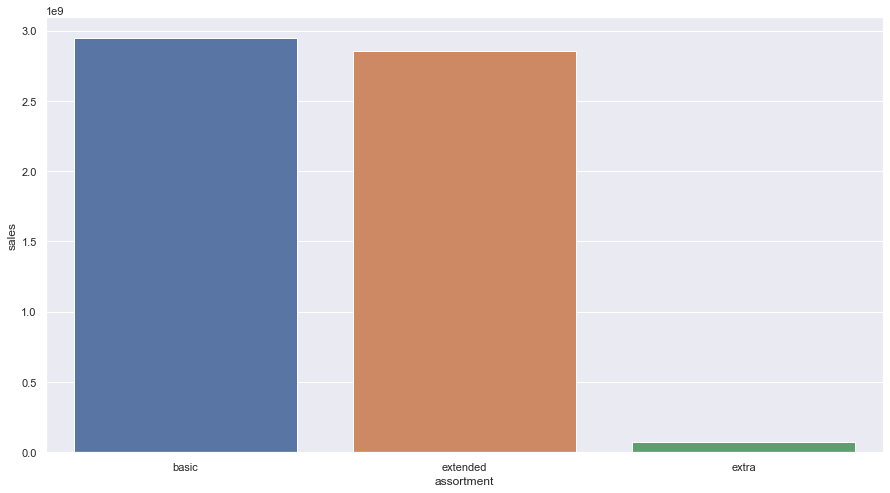

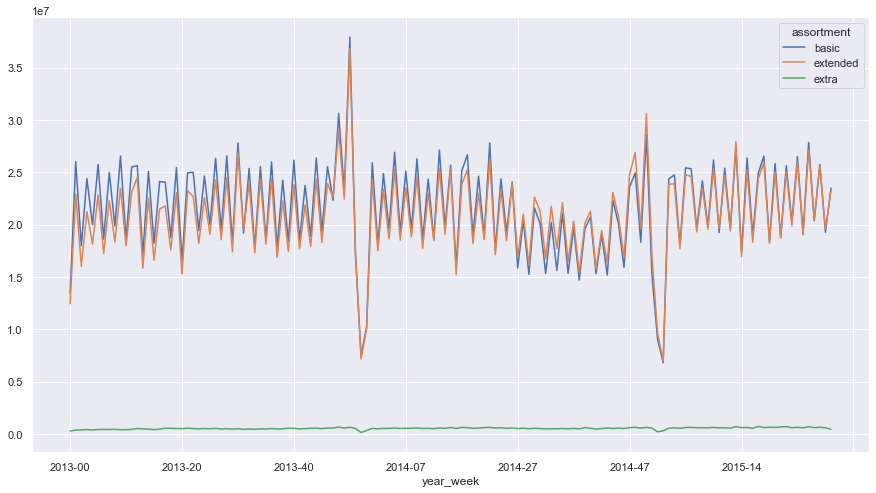

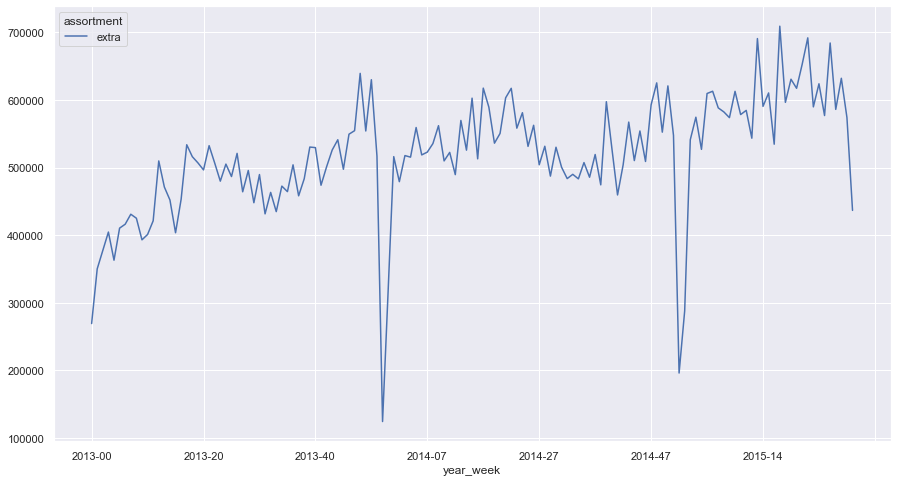

In [92]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


#### H2) Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.


<AxesSubplot:>

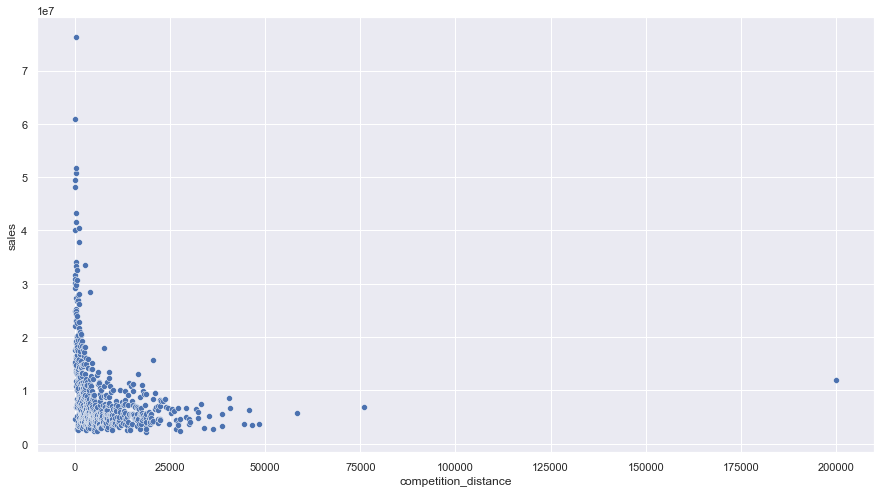

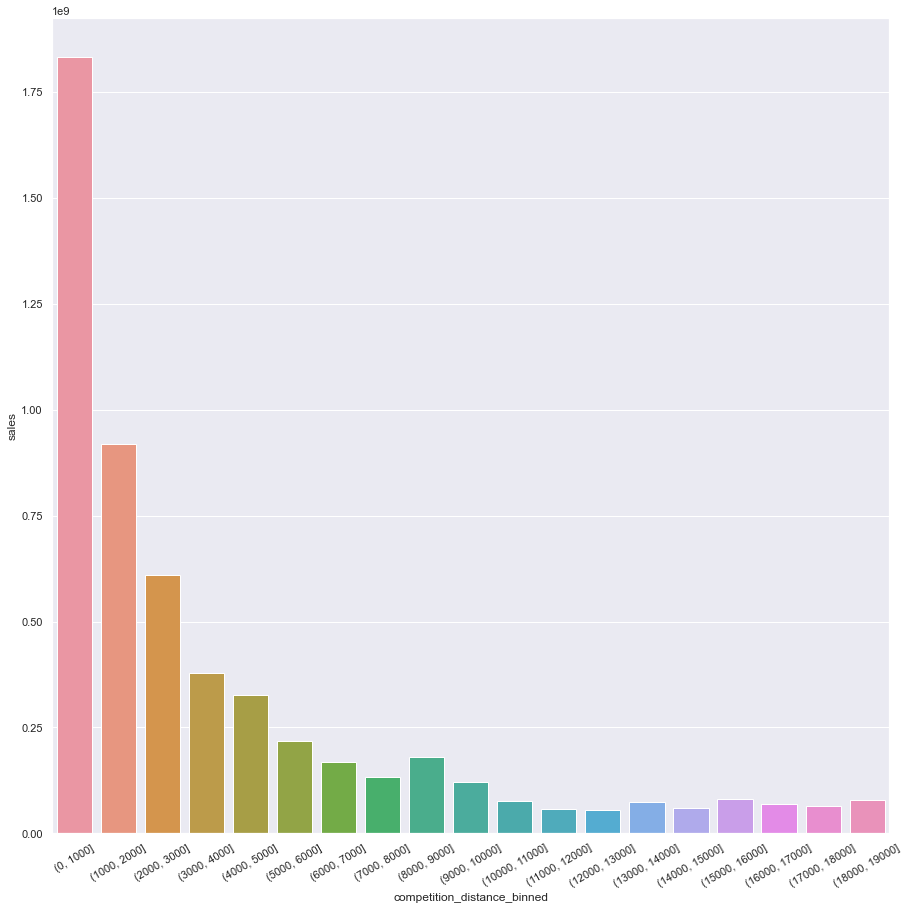

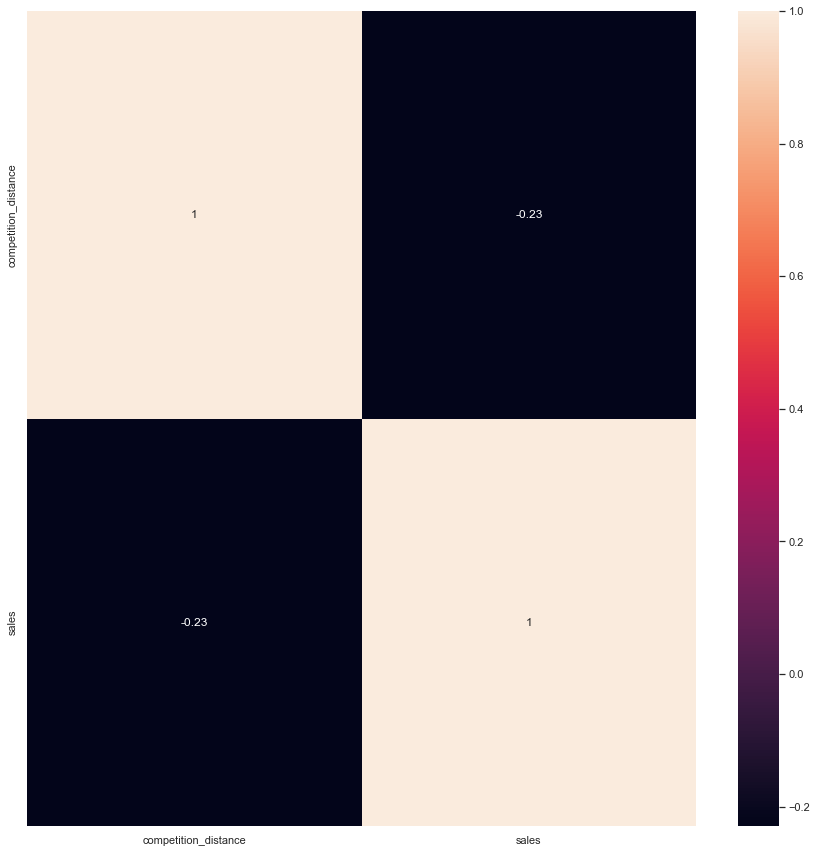

In [93]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data=aux1)


# creating groups
bins= list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


plt.figure(figsize=(15,15))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=30)

plt.figure(figsize=(15,15))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

In [94]:
aux1.sample(15)

,competition_distance,sales,competition_distance_binned
310,4160.00000,4747749,"(4000.0, 5000.0]"
445,8260.00000,6385260,"(8000.0, 9000.0]"
570,17340.00000,5485348,"(17000.0, 18000.0]"
578,18020.00000,5428994,"(18000.0, 19000.0]"
386,6250.00000,3348689,"(6000.0, 7000.0]"
617,23130.00000,7973232,NaN
323,4450.00000,9834814,"(4000.0, 5000.0]"
384,6190.00000,3348791,"(6000.0, 7000.0]"
547,15340.00000,9828244,"(15000.0, 16000.0]"
152,1710.00000,20541692,"(1000.0, 2000.0]"


#### H3) Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES MAIS RECENTES vendem MAIS

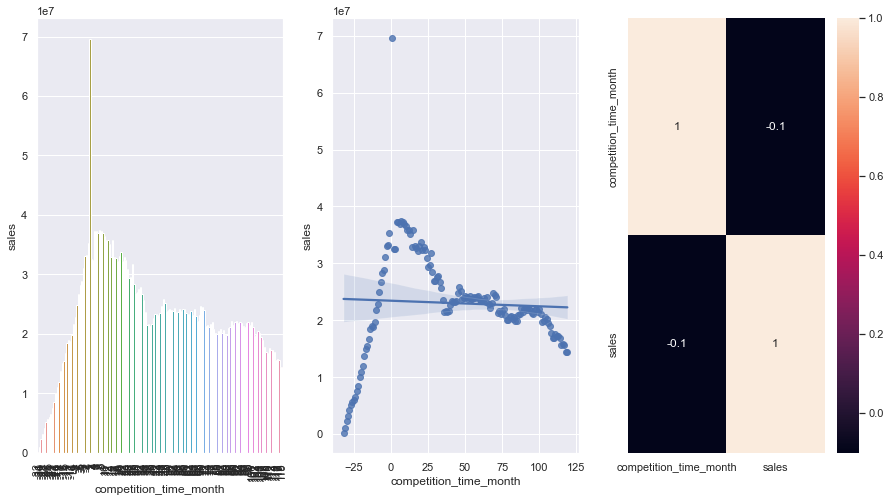

In [95]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

#plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#plt.figure(figsize=(15,15))
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H4) Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos após um certo tempo de promoção.

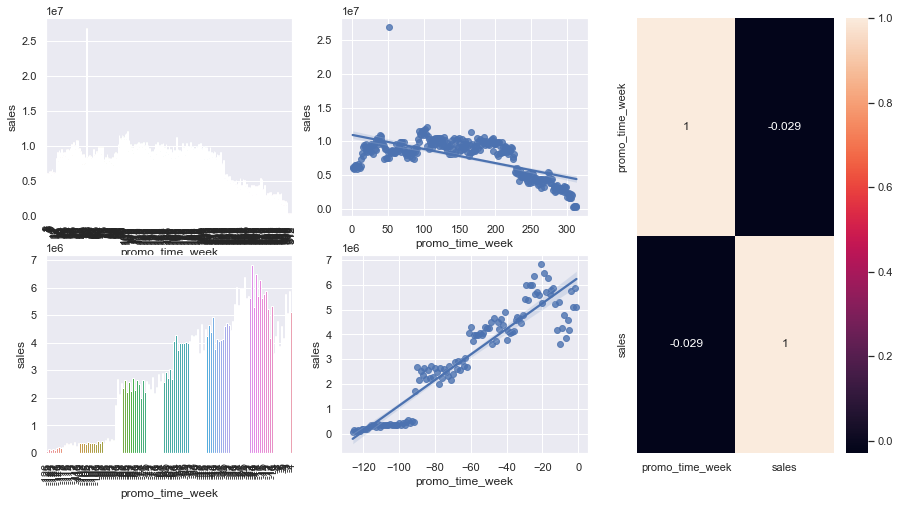

In [96]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promocao extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promocao regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### <s>H5) Lojas com mais dias de promoção deveriam vender mais.</s>

#### H6) Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [97]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


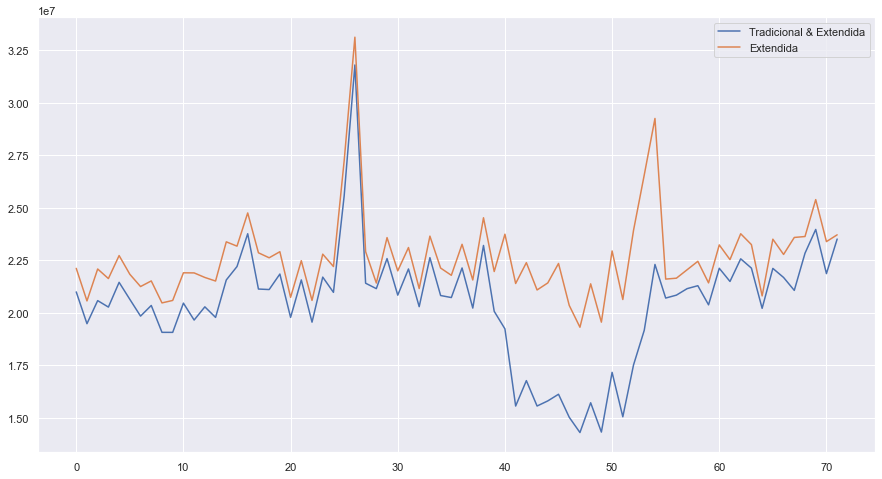

In [98]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

#### H7) Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

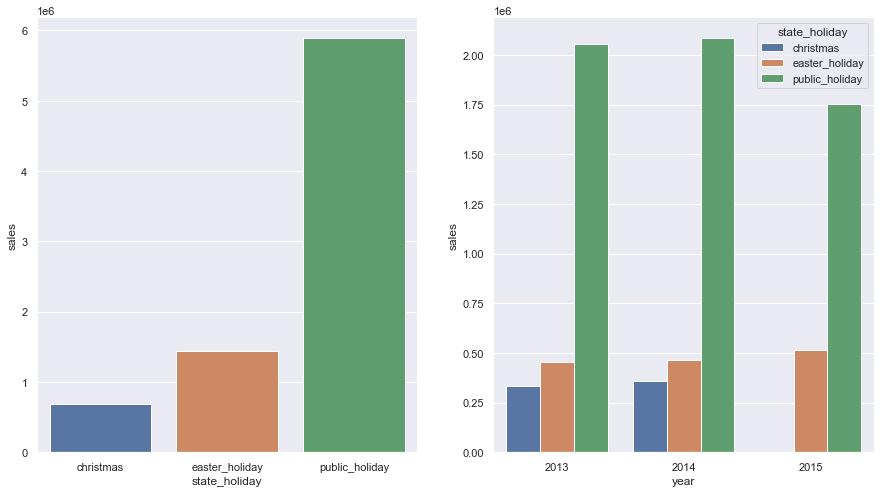

In [99]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data = aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#### H8) Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

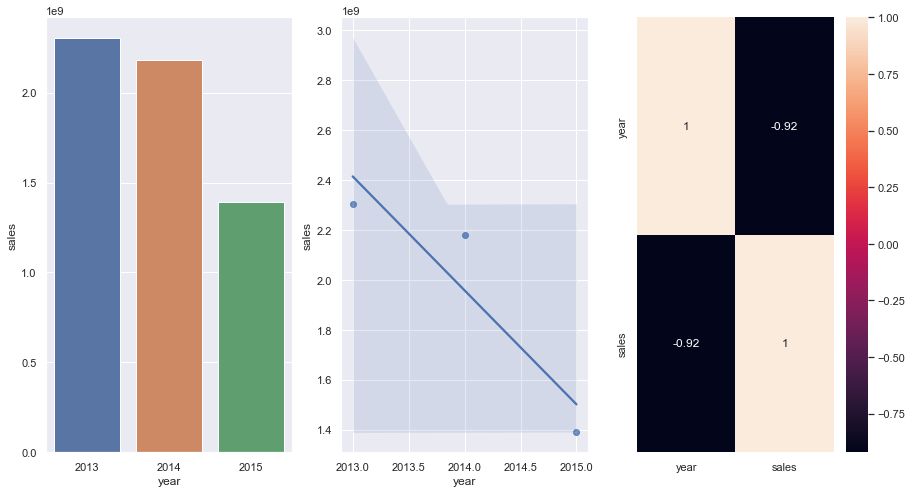

In [100]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H9) Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos durante o segundo semestre.

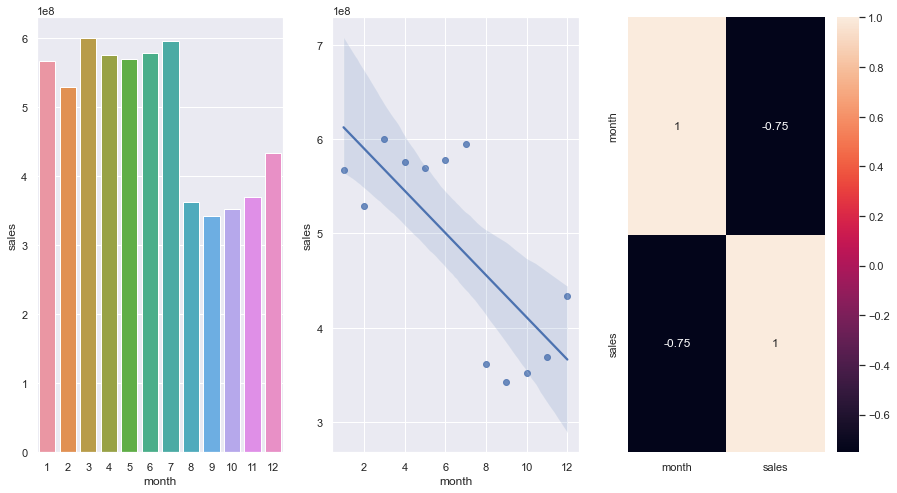

In [101]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H10) Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

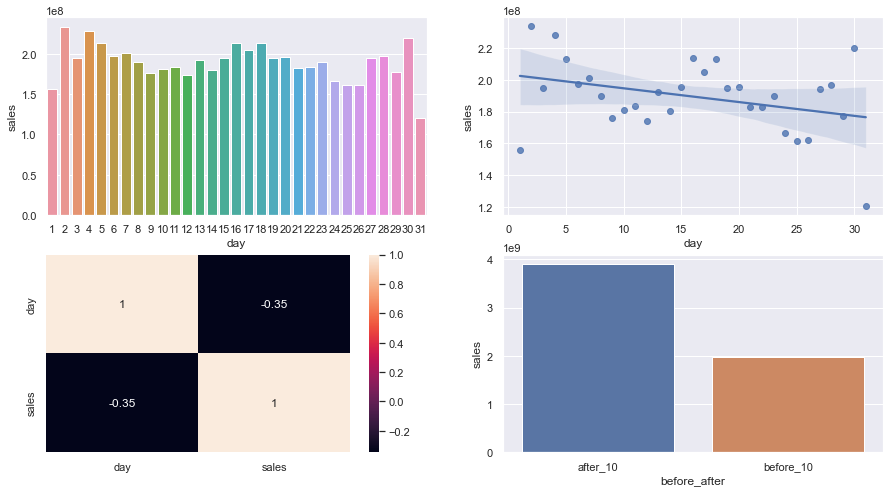

In [102]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
            
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

#### H11) Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana.

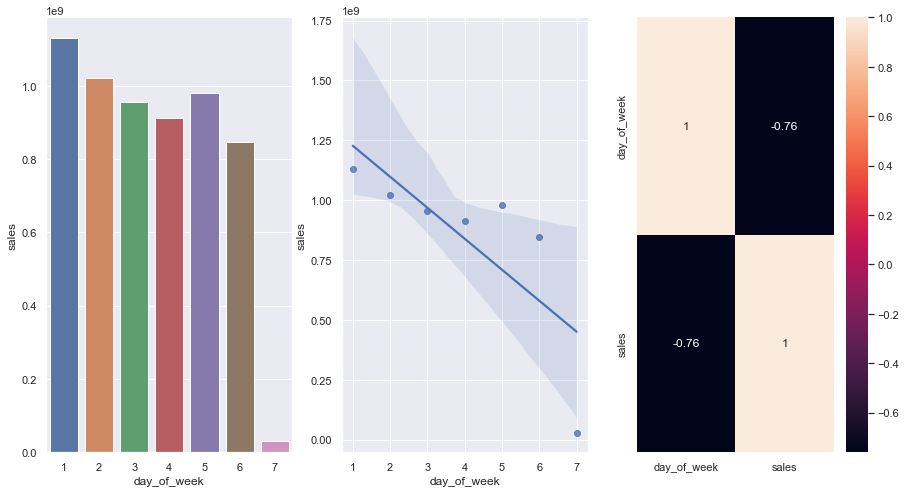

In [103]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H12) Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

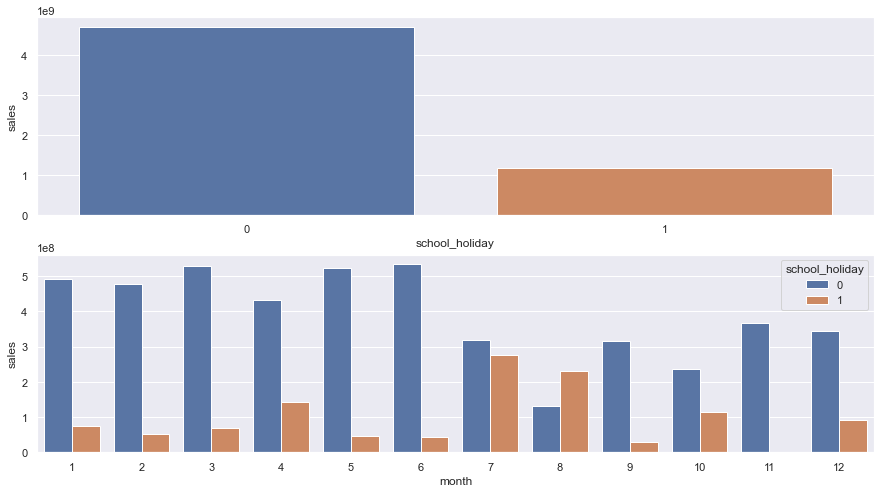

In [104]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

#### 6.2.1) Resumo das Hipoteses

In [105]:
from tabulate import tabulate

In [106]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 6.3) Multivariated Analysis

#### 6.3.1) Numerical  Attributes

<AxesSubplot:>

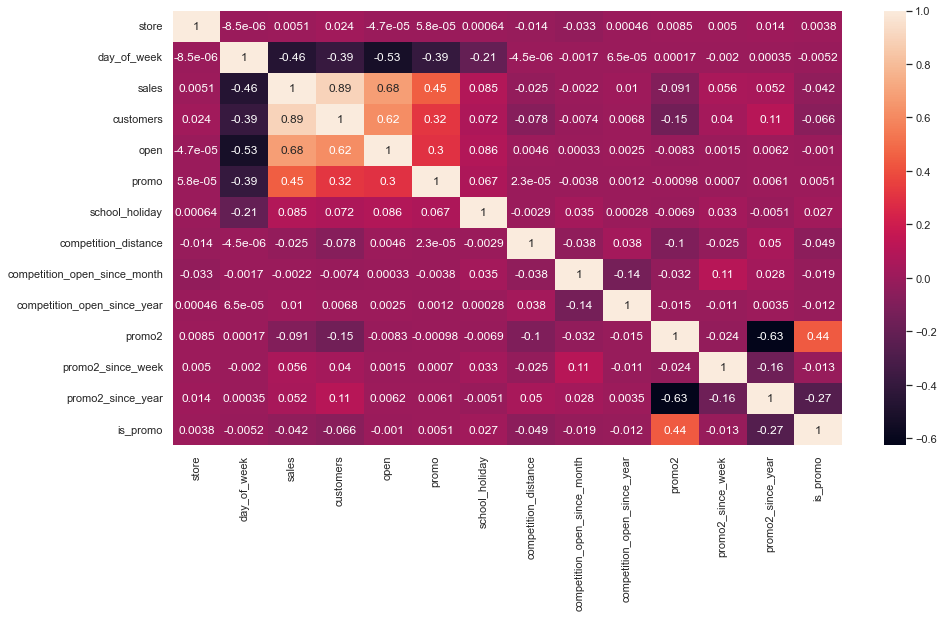

In [107]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#### 6.3.2) Categorical Attributes

<AxesSubplot:>

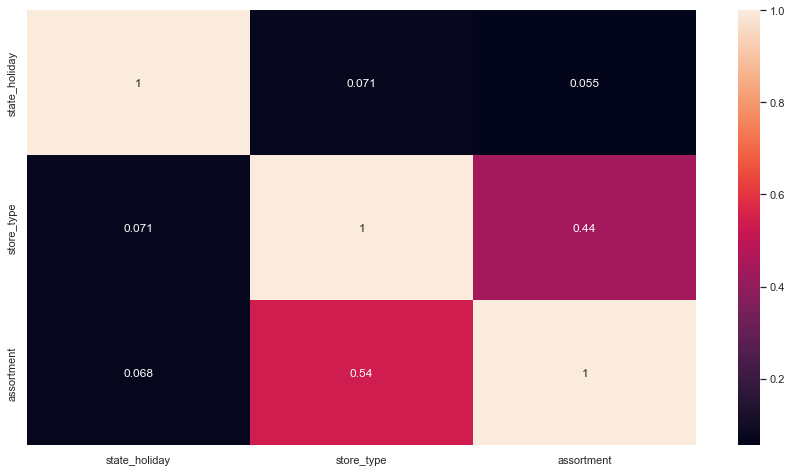

In [108]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)


sns.heatmap(d, annot=True)

## 7) Data Preparation

In [218]:
df5 = df4

### 7.1) Normalization

### 7.2) Rescaling

In [219]:
a = df5.select_dtypes(include=['int64', 'float64'])

<AxesSubplot:xlabel='promo_time_week'>

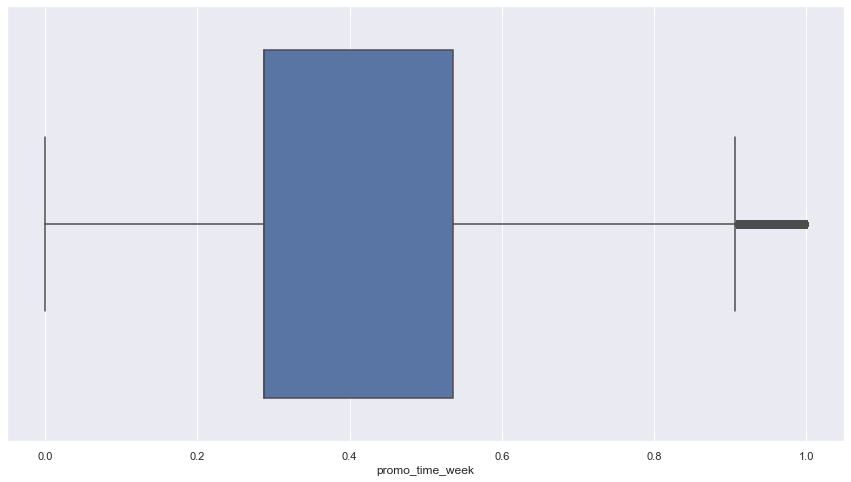

In [220]:
sns.boxplot(df5['promo_time_week'])

In [221]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/encoding_competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/encoding_competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/encoding_promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

### 7.3) Transformacao

#### 7.3.1) Encoding

In [216]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 7.3.2) Response Variable Transformation

In [114]:
df5['sales'] = np.log1p(df5['sales'])

#### 7.3.3) Nature Transformation

In [115]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [116]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.56865,1,1,2,1,-0.17097,9,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
1,2,5,2015-07-31,8.71029,1,1,0,1,-0.28387,11,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
2,3,5,2015-07-31,9.02582,1,1,0,1,1.90323,12,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
3,4,5,2015-07-31,9.54653,1,1,2,3,-0.27581,9,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
4,5,5,2015-07-31,8.48115,1,1,0,1,4.44839,4,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252


<AxesSubplot:xlabel='sales', ylabel='Density'>

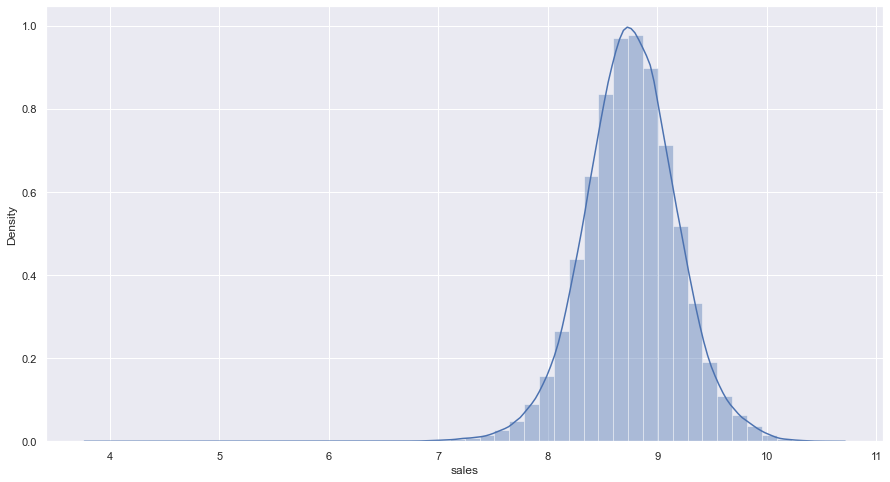

In [117]:
sns.distplot(df5['sales'])

## 8) Feature Selection

In [118]:
df6 = df5

### 8.1) Split dataframe into training and test dataset

In [119]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.56865,1,1,2,1,-0.17097,9,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
1,2,5,2015-07-31,8.71029,1,1,0,1,-0.28387,11,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
2,3,5,2015-07-31,9.02582,1,1,0,1,1.90323,12,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
3,4,5,2015-07-31,9.54653,1,1,2,3,-0.27581,9,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
4,5,5,2015-07-31,8.48115,1,1,0,1,4.44839,4,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252


In [120]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [121]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [122]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 8.2) Boruta as Feature Selector

In [123]:
## training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
#
## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

#### 8.2.1) Best Features from Boruta

In [124]:
#cols_selected = boruta.support_tolist()
#
## best features
#x_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_select_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

### 8.3) Manual Feature Selection

In [125]:
cols_selected_boruta = [
                       'store',
                       'promo',
                       'store_type',
                       'assortment',
                       'competition_distance',
                       'competition_open_since_month',
                       'competition_open_since_year',
                       'promo2',
                       'promo2_since_week',
                       'promo2_since_year',
                       'competition_time_month',
                       'promo_time_week',
                       'day_of_week_sin',
                       'day_of_week_cos',
                       'month_cos',
                       'month_sin',
                       'day_sin',
                       'day_cos',
                       'week_of_year_cos',
                       'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta


## 9) Machine Learning Modelling

In [126]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

### 9.1) Average Model

In [127]:
aux1 = x_test
aux1['sales'] = y_test

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']


# perfomance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80035,0.20640,1835.13554


In [128]:
x_test = X_test[cols_selected_boruta]

### 9.2) Linear Regression Model

In [129]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# perfomance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.08977,0.29269,2671.04922


### 9.3) Linear Regression Regularized Model - Lasso

In [130]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# perfomance
lrr_result = ml_error('Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.70488,0.28911,2744.45174


### 9.4) Random Forest Regressor

In [131]:
## model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
#
## prediction
#yhat_rf = rf.predict(x_test)
#
## performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm(yhat_rf))
#rf_result

### 9.5) XGBost Regressor

In [132]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.74013,0.94950,7331.02985


In [133]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

cols_selected_boruta_full = cols_selected_boruta
cols_selected_boruta_full.extend(feat_to_add)

In [134]:
x_training = X_train[cols_selected_boruta_full]

#### 9.2.1) Linear Regression Model - Cross Validation

In [135]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


#### 9.3.1) Lasso - Cross Validation

In [136]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


#### 9.4.1) Random Forest Regressor - Cross Validation

In [137]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

#### 9.5.1) XGBost Regressor - Cross Validation

In [138]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.19+/-588.54,0.95+/-0.0,7715.18+/-689.35


### 9.6) Compare Model's Perfomance

#### 9.6.1) Single Performance

In [139]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, xgb_result])
modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80035,0.20640,1835.13554
0,Linear Regression,1867.08977,0.29269,2671.04922
0,Linear Regression Lasso,1891.70488,0.28911,2744.45174
0,XGBoost Regressor,6683.74013,0.94950,7331.02985


#### 9.6.2) Real Perfomance - Cross Validation

In [140]:
modelling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv])
modelling_results_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,XGBoost Regressor,7049.19+/-588.54,0.95+/-0.0,7715.18+/-689.35


## 10) Hyperparameter Fine Tuning

### 10.1) Random Search

In [141]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 10

In [142]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#
#    # performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#    
#final_result

### 10.2) Final Model

In [143]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }

In [144]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,762.88734,0.11513,1094.74613


## 11) Business Performance

In [163]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 11.1) Business Performance

In [179]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAP
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [182]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107759.25781,104341.32437,111177.19125,3417.93344,0.60677
908,909,221086.09375,213197.41574,228974.77176,7888.67801,0.51752
169,170,203273.18750,201883.98758,204662.38742,1389.19992,0.34219
901,902,197851.04688,196501.23472,199200.85903,1349.81216,0.33628
875,876,195960.60938,191920.21416,200001.00459,4040.39521,0.32298


<AxesSubplot:xlabel='store', ylabel='MAPE'>

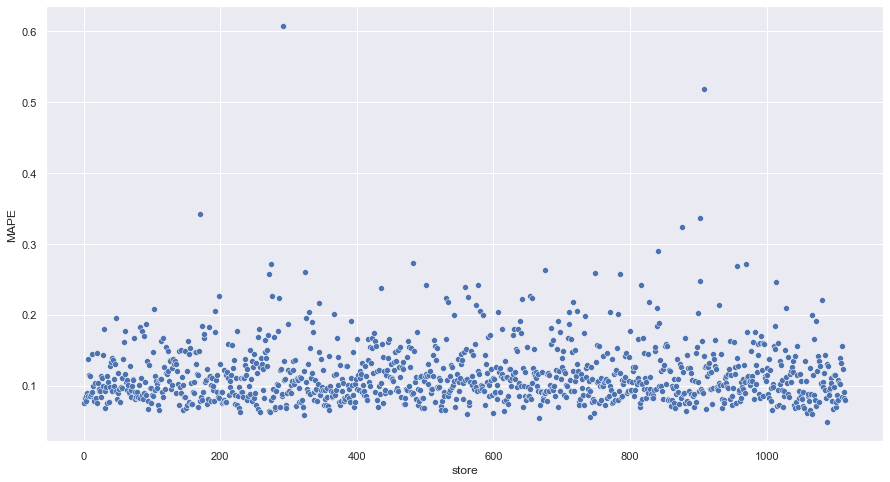

In [184]:
sns.scatterplot(x='store', y='MAPE', data=df92)

### 11.2) Total Performance

In [192]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$287,460,224.00"
1,worst_scenario,"R$286,606,360.78"
2,best_scenario,"R$288,314,133.20"


### 11.3) Machine Learning Performance

In [193]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

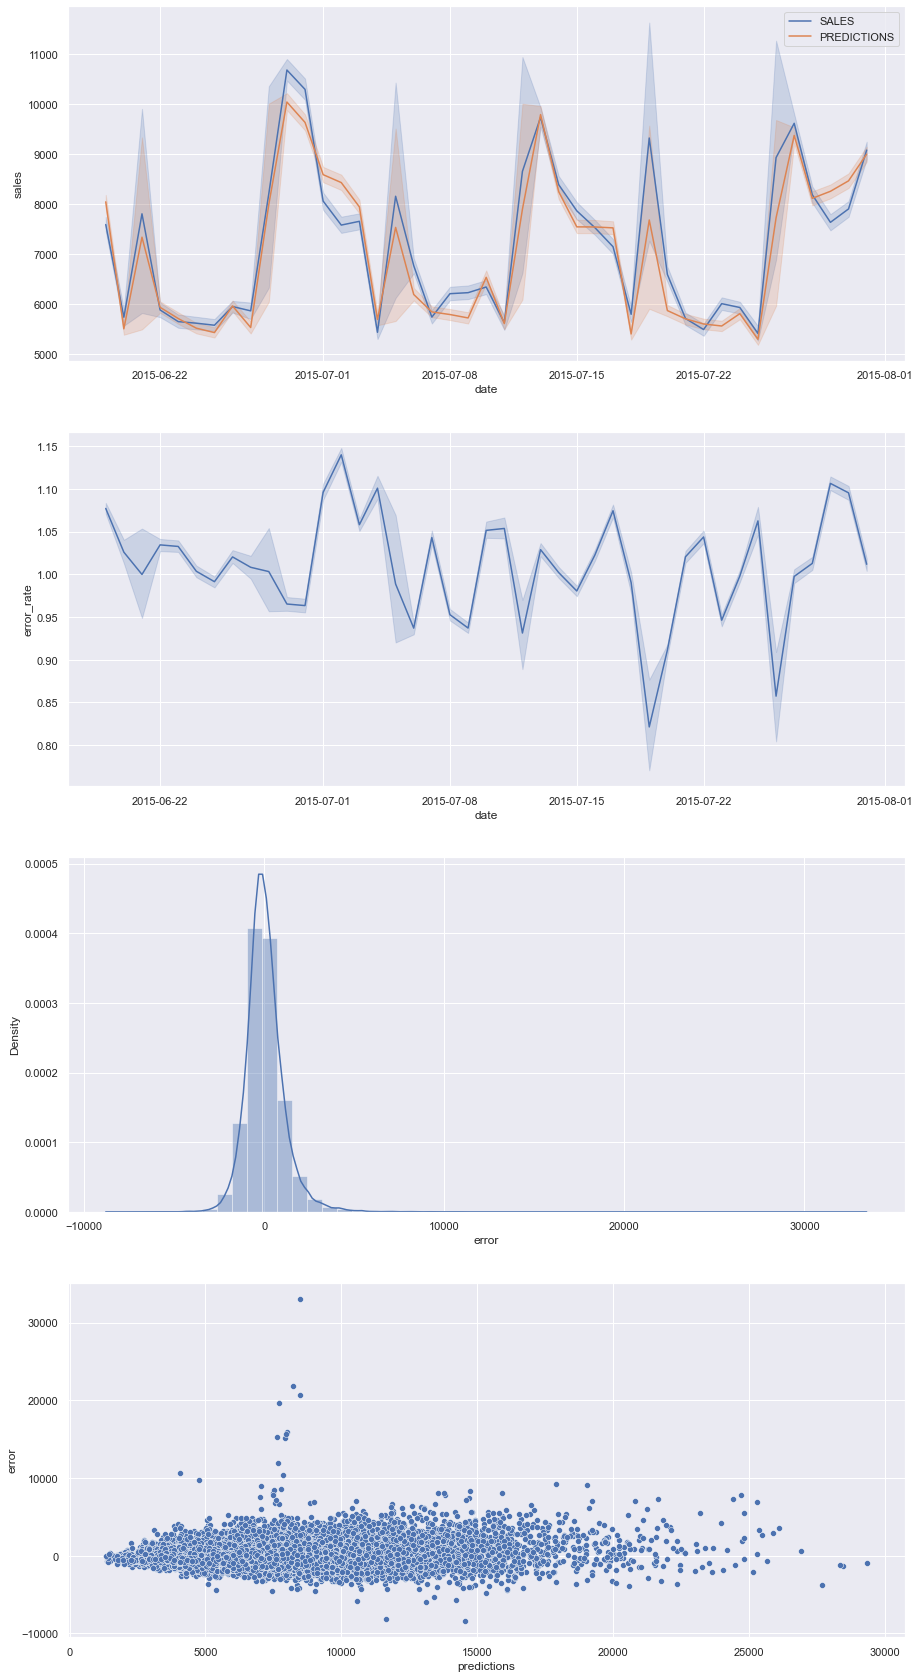

In [205]:
plt.figure(figsize=[15, 30])

plt.subplot(4, 1, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')


plt.subplot(4, 1, 2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(4, 1, 3)
sns.distplot(df9['error'])

plt.subplot(4, 1, 4)
sns.scatterplot(df9['predictions'], df9['error'])

## 12) Deploy Model to Production

In [145]:
pickle.dump(model_xgb_tuned, open('/home/joaohenritm/repos/Rossmann/model_rossmann.pkl', 'wb'))

### 12.1) Rossmann Class

In [55]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
 
class Rossmann(object):
    def __init__(self):
        self.home_path='/home/joaohenritm/repos/Rossmann/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/encoding_competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/encoding_competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/encoding_promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler            = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        state = 1
        
    def data_cleaning(self, df1):
        
        # Renaming Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
    
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        
        # rename
        df1.columns = cols_new
        
        df1['date'] = pd.to_datetime(df1['date'])
        
        # fillout NA
        #competition_distance              
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
        
        #competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        
        #competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        
        #promo2_since_week               
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        
        #promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
        #promo_interval                  
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo 2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_engineering(self, df2):
        ### 4.3) Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week']= ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


        # assortment 
        df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## 5) Filtering Rows and Columns

        ### 5.1) Filtering Rows

        df2 = df2[df2['open'] != 0]

        ### 5.2) Filtering Columns

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self, df5):
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        #### 7.3.1) Encoding

        # state holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #### 7.3.3) Nature Transformation

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
        
        cols_selected = [
                       'store',
                       'promo',
                       'store_type',
                       'assortment',
                       'competition_distance',
                       'competition_open_since_month',
                       'competition_open_since_year',
                       'promo2',
                       'promo2_since_week',
                       'promo2_since_year',
                       'competition_time_month',
                       'promo_time_week',
                       'day_of_week_sin',
                       'day_of_week_cos',
                       'month_cos',
                       'month_sin',
                       'day_sin',
                       'day_cos',
                       'week_of_year_cos',
                       'week_of_year_sin']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

### 12.2) API Handler

In [33]:
import pickle
import pandas as pd

from flask           import Flask, request, Response
from rossmann.Rossmann import Rossmann

# load model
model = pickle.load(open('/home/joaohenritm/repos/Rossmann/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossman_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate Rossmann Class
        pipeline = Rossmann()
            
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

### 13.3) API Tester

In [49]:
import requests

In [50]:
df10 = pd.read_csv('data/test.csv')

In [68]:
# merge test + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 22, 12, 29])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [69]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [70]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [71]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [72]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.00000,1,regular_day,0,a,extended,1070.00000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6828.04688
1,22,4,2015-09-17T00:00:00.000Z,1.00000,1,regular_day,0,a,basic,1040.00000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4606.23340
2,24,4,2015-09-17T00:00:00.000Z,1.00000,1,regular_day,0,a,extended,4590.00000,...,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,10267.01270
3,29,4,2015-09-17T00:00:00.000Z,1.00000,1,regular_day,0,d,extended,2170.00000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,6549.93506
4,12,3,2015-09-16T00:00:00.000Z,1.00000,1,regular_day,0,a,extended,1070.00000,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6853.82031


In [73]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 12 will sell R$275,131.80 in the next 6 weeks
Store Number 22 will sell R$175,075.16 in the next 6 weeks
Store Number 24 will sell R$414,497.94 in the next 6 weeks
Store Number 29 will sell R$269,590.09 in the next 6 weeks


,store,prediction
0,22,175075.16150


In [66]:
d1

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.00000,1,regular_day,0,a,basic,1040.00000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4606.23340
1,22,3,2015-09-16T00:00:00.000Z,1.00000,1,regular_day,0,a,basic,1040.00000,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4667.09961
2,22,2,2015-09-15T00:00:00.000Z,1.00000,1,regular_day,0,a,basic,1040.00000,...,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5351.63037
3,22,1,2015-09-14T00:00:00.000Z,1.00000,1,regular_day,1,a,basic,1040.00000,...,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6197.39209
4,22,6,2015-09-12T00:00:00.000Z,1.00000,0,regular_day,0,a,basic,1040.00000,...,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,2045.30054
5,22,5,2015-09-11T00:00:00.000Z,1.00000,0,regular_day,1,a,basic,1040.00000,...,2015,9,11,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,3770.04150
6,22,4,2015-09-10T00:00:00.000Z,1.00000,0,regular_day,1,a,basic,1040.00000,...,2015,9,10,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,3596.68359
7,22,3,2015-09-09T00:00:00.000Z,1.00000,0,regular_day,1,a,basic,1040.00000,...,2015,9,9,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,3603.74146
8,22,2,2015-09-08T00:00:00.000Z,1.00000,0,regular_day,1,a,basic,1040.00000,...,2015,9,8,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,3681.95459
9,22,1,2015-09-07T00:00:00.000Z,1.00000,0,regular_day,1,a,basic,1040.00000,...,2015,9,7,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,3825.77905
